# Assessing Credit Risk Case Study

### Dataset: https://www.kaggle.com/laotse/credit-risk-dataset

## Problem Statement:

Banking institutions incur large financial losses when customers default on their loans. It is difficult to properly assess an indivual's likelihood of default from single factors alone. To minimize loss, loan providers must appropriately assess the likelihood of a customer to default on a loan based on a myriad of factors. 

## Proposal:

The ability to correctly identify individuals who may default on a personal loan is of utmost importance in the personal loan industry. Using a combination of both personal information and credit history, we can build a model to assess if an individual is high risk for lending, to mitigate loss through loan default.

A predictive model will be built using existing loan data. The dataset has the following variables:

Loan status (defaulted or not)
Borrower age
Borrower income
Borrower home ownership status
Borrower employment type
Borrower default history
Borrower credit history length
Loan grade
Loan amount
Loan interest rate
Loan payment to borrower income ratio

Both RandomForest and Support Vector Classifier (SVC) models will be built to find best performing model. The performance of each model will be evaluated using the Area Under the Curve (AUC) metric.

## Exploratory Data Analysis

In [1755]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import category_encoders as ce
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

In [1756]:
df = pd.read_csv('credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


We will view the Pandas Profiling report to see the data distribution

In [1757]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_file("credit_profiling_report.html")

We can see that the target class, loan_status, is imbalanced from our Pandas Profiling report. Downsampling will be applied to give an even distribution of the target.

The current distribution of defaulted (1), and not defaulted (0) loans in the dataset


<AxesSubplot:ylabel='loan_status'>

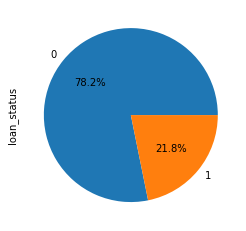

In [1758]:
# visualize class distribution of target
print('The current distribution of defaulted (1), and not defaulted (0) loans in the dataset')
df.loan_status.value_counts().plot(kind='pie',autopct='%1.1f%%')

In [1759]:
# Separate majority and minority classes
df_majority = df[df.loan_status==0]
df_minority = df[df.loan_status==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, replace=False, n_samples=7108, random_state=12)
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [1760]:
# shorten long variable names
df_downsampled = df_downsampled.rename(columns={'person_age': 'age', 'person_income': 'income',
                        'person_home_ownership': 'home_stat',
                        'person_emp_length': 'length_emp',
                        'loan_int_rate': 'int_rate', 'loan_percent_income': 'DTI',
                        'cb_person_default_on_file': 'past_default',
                        'cb_person_cred_hist_length': 'cred_hist'})

In [1761]:
# remove erroneous values
df_downsampled = df_downsampled[df_downsampled['age'] < 100]
df_downsampled = df_downsampled[df_downsampled['length_emp'] < 70]

In [1762]:
# select only personal loans
df_downsampled = df_downsampled[df_downsampled['loan_intent'] == 'PERSONAL']

In [1763]:
# check columns with null values
print('null value count by variable \n', df_downsampled.isnull().sum(axis = 0))

null value count by variable 
 age               0
income            0
home_stat         0
length_emp        0
loan_intent       0
loan_grade        0
loan_amnt         0
int_rate        204
loan_status       0
DTI               0
past_default      0
cred_hist         0
dtype: int64


In [1764]:
# fill NaN values with mean
df_downsampled = df_downsampled.fillna(df_downsampled.mean())

In [1765]:
# remove loan intent column (all personal now)
df_downsampled.drop('loan_intent', axis=1, inplace=True)

In [1777]:
# create dummy variables for categorical data
df = pd.concat([df_downsampled,pd.get_dummies(df_downsampled['home_stat'], prefix='home')],axis=1)
df = pd.concat([df,pd.get_dummies(df['loan_grade'], prefix='loan_grd')],axis=1)
df = pd.concat([df,pd.get_dummies(df['past_default'], prefix='past_default')],axis=1)

In [1778]:
# remove original categorical data columns
df.drop(['home_stat', 'loan_grade', 'past_default'], axis=1, inplace=True)

In [1779]:
# scale data 
arr_df = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(arr_df)
df = pd.DataFrame(x_scaled, columns=df.columns) 

In [1780]:
# split target and non-target
X = df.drop(columns='loan_status')
y = df['loan_status']

In [1781]:
# test train split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,stratify = y,random_state = 22)

## Feature Selection

I am using the SelectKbest algorithm from Sklearn to evaluate my features for importance. We will view the top 15 features in the training dataset.

In [1782]:
# Fit kbest to training data to view features by importance
KBest = KBest.fit(X_train,y_train)

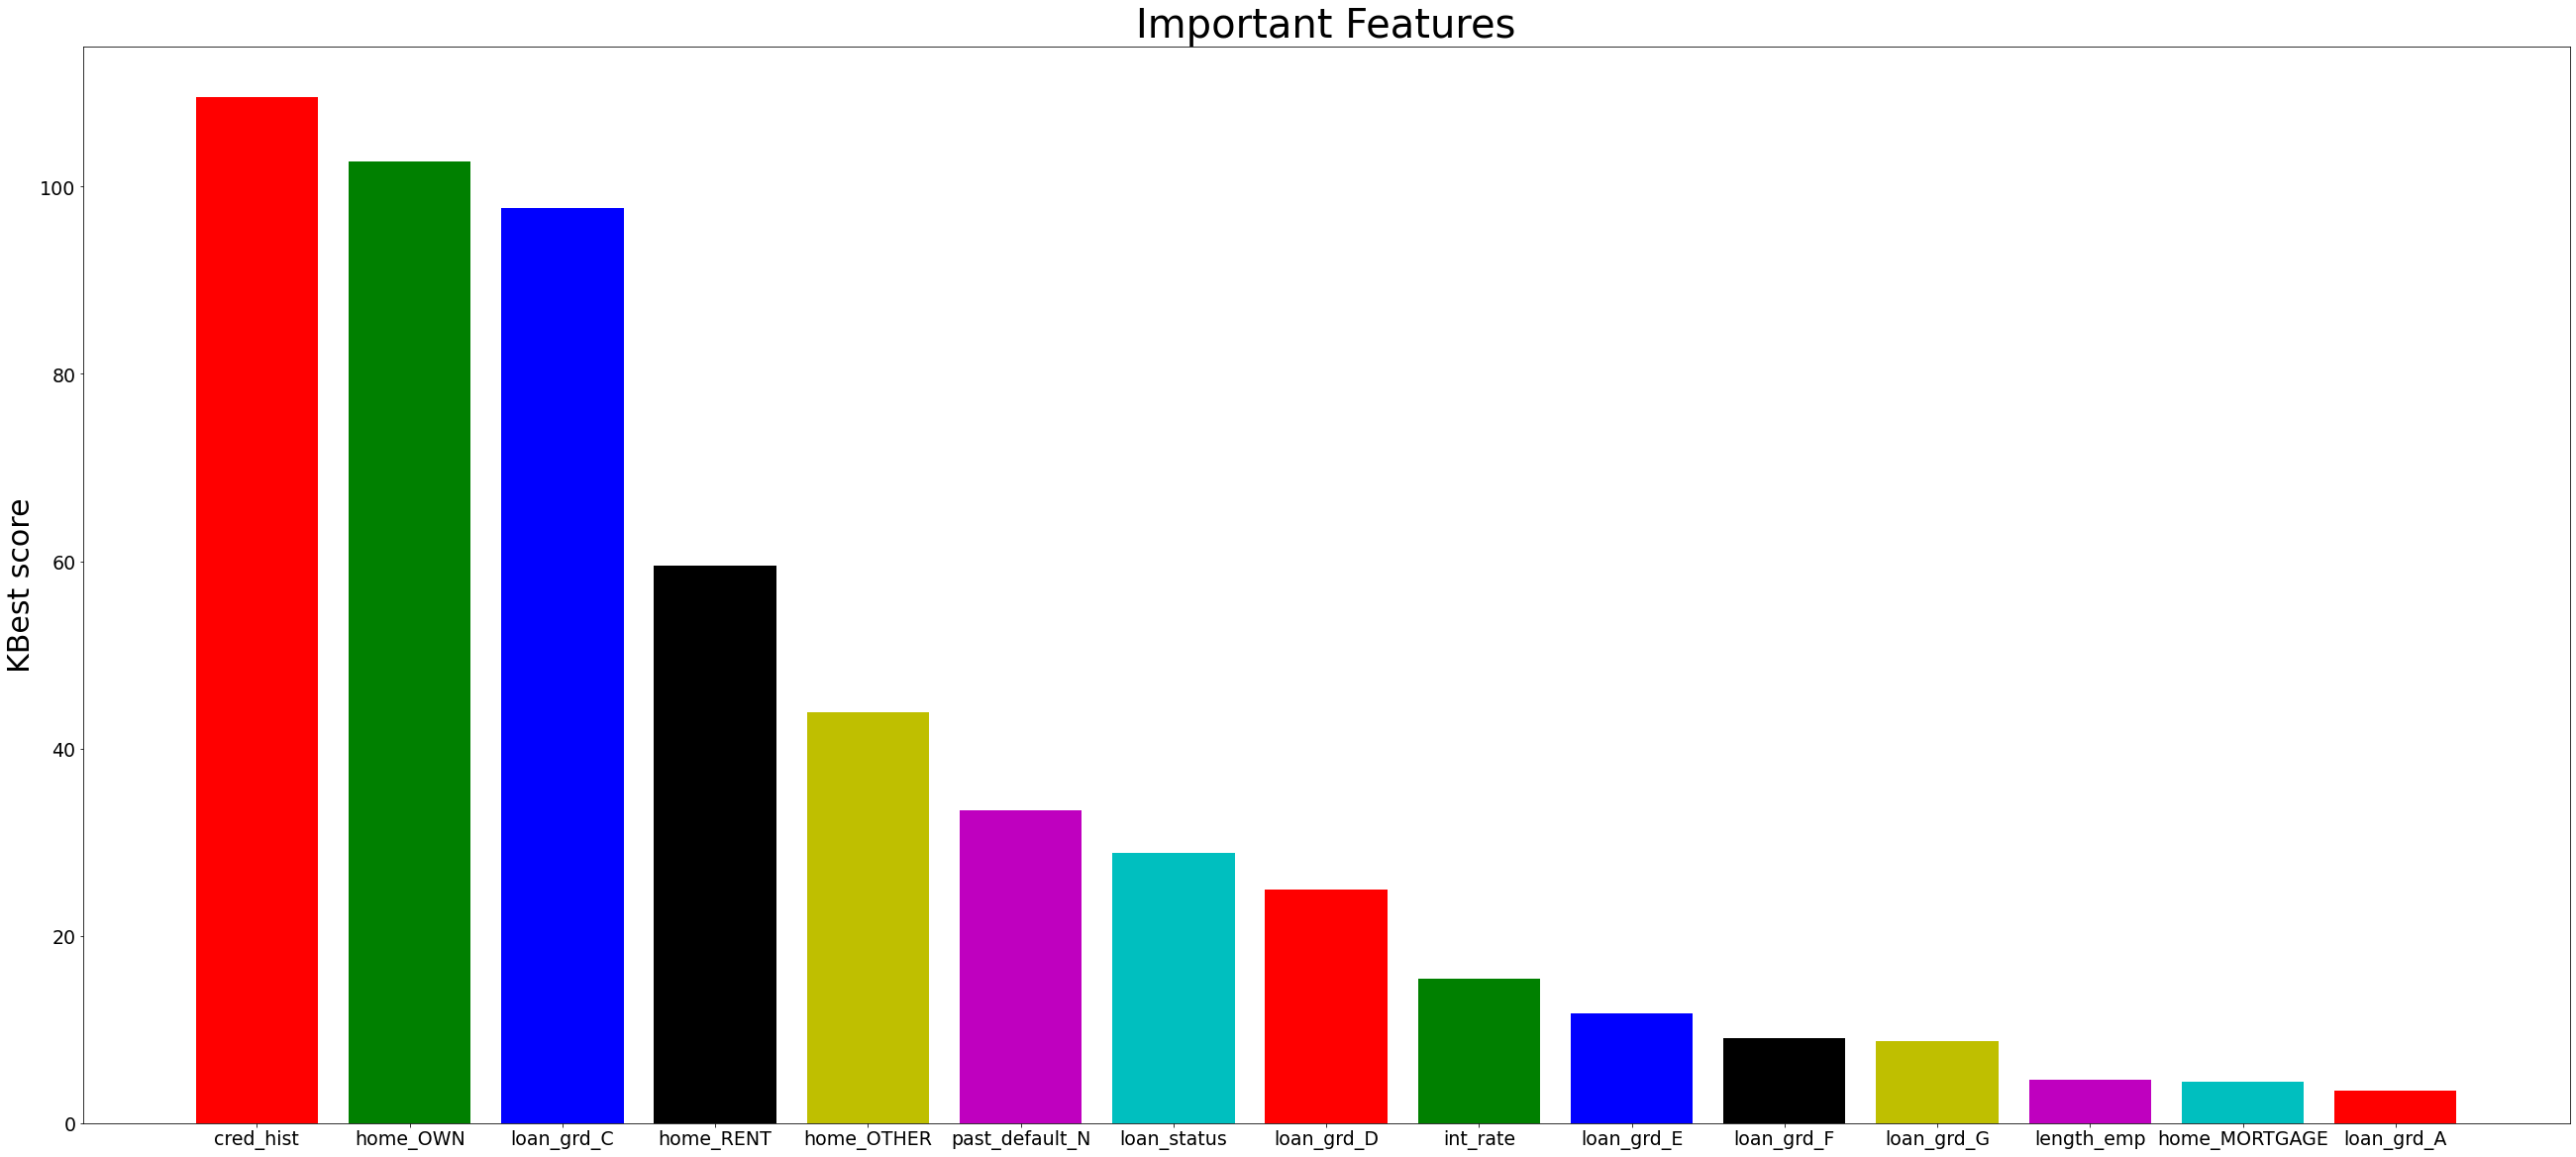

In [1785]:
indice = np.argsort(KBest.scores_)[::-1]

# get top 15 feature names
features = []
for i in range(15):
    features.append(df.columns[indice[i]])

my_colors = 'rgbkymc'
    
#plot by Kbest scores
plt.figure(figsize=(45, 20))
plt.bar(features, KBest.scores_[indice[range(15)]], color=my_colors)
plt.xticks(size = 19)
plt.yticks(size = 19)
plt.title('Important Features', fontsize=40)
plt.ylabel('KBest score', fontsize=30)
plt.show()

From this graph we can see that credit history, owning a home, and having a loan grade of C are the most important features for building a model. However, to avoid underfitting the model, I chose to keep all features with scores higher than length employed. I chose to stop at length employed because this had the greatest Kbest score drop compared to the next higher scored feature.

In [1773]:
# Transform X with chosen k value
KBest = SelectKBest(score_func = chi2, k=12)
KBest = KBest.fit(X_train,y_train)
X_train = KBest.transform(X_train)
X_test = KBest.transform(X_test)

## Model Selection and Evaluation
SVC will be fine tuned by kernel, C value, and gamma.
RandomForest will be fine tuned by max_depth, and min_samples_leaf

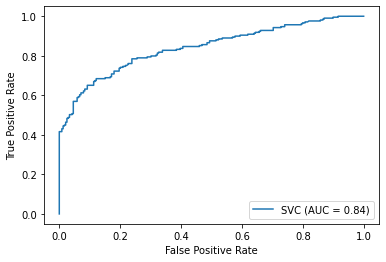

In [1774]:
# Train SVC model
svc = SVC(random_state=22, kernel='rbf', C=10, gamma=10)
svc.fit(X_train, y_train)
plot_roc_curve(svc, X_test, y_test).plot(ax=ax, alpha=0.8)

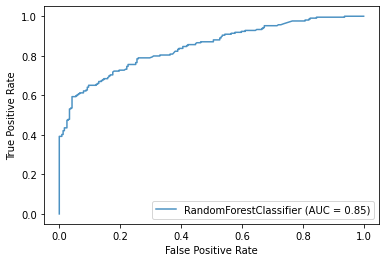

In [1775]:
# Train Random Forest model
rfc = RandomForestClassifier(random_state=22, max_depth = 5, min_samples_leaf = 15)
rfc.fit(X_train, y_train)
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc, X_test, y_test, ax=ax, alpha=0.8)

## Conclusion

The RandomForest model performed slightly better with an AUC score of 0.85. The SVC model also performed well, coming in just a percent lower at 0.84.

According to Experian.com, there is currently $305 billion dollars in personal loan debt in the United States <sup>1</sup>. The current default rate on personal loans is 3.3%<sup>2</sup>. Assuming there are no other models in place, this model can reduce the current defaulted rate of 3.3% by 85%, resulting in a savings of 8.55 billion dollars in the U.S. 




<sup>1</sup> US loan debt: [link](https://www.experian.com/blogs/ask-experian/research/consumer-debt-study/#:~:text=Personal%20loans%3A%20Personal%20loan%20debt%20totals%20%24305%20billion.)

<sup>2</sup> Default rates: [link](https://www.lendingtree.com/personal/personal-loans-statistics/#:~:text=Delinquency%20rates%20(60%20days%20or,and%20credit%20cards%20(1.8%25))